In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/MDS0_K278_NguyenYenQuynhDan/NLP'

/content/gdrive/MyDrive/MDS0_K278_NguyenYenQuynhDan/NLP


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install underthesea
!pip install demoji
!pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 10.0 MB/s 
     |████████████████████████████████| 965 kB 65.3 MB/s 
     |████████████████████████████████| 581 kB 53.7 MB/s 
     |████████████████████████████████| 235 kB 55.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 12.1 MB/s 


In [5]:
!pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 12.8 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=ea64b0edef788a6b8038babe9bd5d1762440166158db58d1e18cf9ad8c2e7a9f
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp


In [6]:
# run 1 lan
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2022-09-27 08:19:29--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  73.5MB/s    in 0.4s    

2022-09-27 08:19:32 (73.5 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2022-09-27 08:19:32--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respo

In [7]:
from vncorenlp import VnCoreNLP
#rdrsegmenter = VnCoreNLP("/Absolute-path-to/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

In [8]:
import pandas as pd
import numpy as np
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df= pd.read_excel('review_full_text_tripadvisor_raw.xlsx')

In [10]:
df.head()

,hotel_name,customer_name,title,full_content,rating,rating_new
0,Hotel des Arts Saigon Mgallery,Anh Tuấn L,Quá Tuyệt Vời Khi Ở Des Arts Sài Gòn,#HôtelDesArtsSaiGon là một sự trải nghiệm tuyệ...,bubble_50,5
1,Hotel des Arts Saigon Mgallery,TRƯƠNG BẰNG,Đáng đồng tiền!,"Dịch vụ cao cấp, phong cách chuyên nghiệp & tậ...",bubble_50,5
2,Hotel des Arts Saigon Mgallery,Phong Thu Vu,huyền bí và ấn tượng,vài dòng note lại về #Mgalery huyền bí... khác...,bubble_50,5
3,Hotel des Arts Saigon Mgallery,monkeyminhvn,love decor and service,Mình rất thích ngắm mái vòm và những khung cửa...,bubble_50,5
4,Hotel des Arts Saigon Mgallery,Ngoc Dung P,"Dễ thương, ấm cúng",Ks không lớn lắm nhưng có lối trang trí ấm cún...,bubble_40,4


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82380 entries, 0 to 82379
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   hotel_name     82380 non-null  object
 1   customer_name  82380 non-null  object
 2   title          82378 non-null  object
 3   full_content   82380 non-null  object
 4   rating         82380 non-null  object
 5   rating_new     82380 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 3.8+ MB


In [12]:
df.columns

Index(['hotel_name', 'customer_name', 'title', 'full_content', 'rating',
       'rating_new'],
      dtype='object')

### Filter Text 

In [13]:
df = df[['full_content','rating_new']]
df.head()

,full_content,rating_new
0,#HôtelDesArtsSaiGon là một sự trải nghiệm tuyệ...,5
1,"Dịch vụ cao cấp, phong cách chuyên nghiệp & tậ...",5
2,vài dòng note lại về #Mgalery huyền bí... khác...,5
3,Mình rất thích ngắm mái vòm và những khung cửa...,5
4,Ks không lớn lắm nhưng có lối trang trí ấm cún...,4


In [14]:
df.shape

(82380, 2)

In [15]:
df.isnull().sum()

full_content    0
rating_new      0
dtype: int64

In [16]:
df.isnull().values.any()

False

=> không có dữ liệu null

In [17]:
df.count()

full_content    82380
rating_new      82380
dtype: int64

In [18]:
df = df.drop_duplicates()

In [19]:
df.count()

full_content    78950
rating_new      78950
dtype: int64

=> có dữ liệu trùng, đã xóa dữ liệu trùng

In [20]:
df['words'] = df['full_content'].map(lambda text: len(text.split()))

In [21]:
df['words'].describe()

count    78950.000000
mean       102.010488
std         69.133728
min          1.000000
25%         56.000000
50%         79.000000
75%        132.000000
max       2144.000000
Name: words, dtype: float64

In [22]:
df['rating_new'].value_counts()

5    54564
4    12527
3     5152
1     4138
2     2569
Name: rating_new, dtype: int64

In [23]:
df.groupby('rating_new').mean('words')

,words
rating_new,
1,160.161672
2,144.235111
3,123.383734
4,103.907639
5,93.158768


Text(0.5, 1.0, 'Number Ratings')

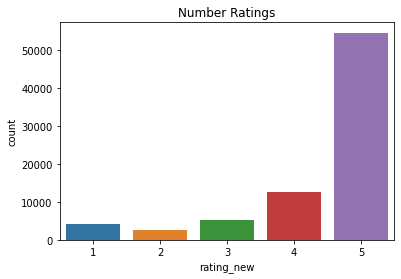

In [24]:
sns.countplot(df['rating_new'])
plt.xlabel('rating_new')
plt.title('Number Ratings')

### Preprocessing


In [25]:
##LOAD EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [26]:
def process_text(text, emoji_dict, teen_dict, english_dict, wrong_lst):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### CONVERT ENGLISH -> VIETNAMESE
        sentence = ' '.join(english_dict[word] if word in english_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        ###### DEL wrong words   
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '                    
    document = new_sentence  
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [27]:
# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [28]:
# tạo elongated: vuiiii -> vui
from itertools import groupby
def elongated_remove(text):
    return ''.join(c for c, _ in groupby(text))

In [29]:
def process_special_word(text):
    new_text = ''
    text_lst = text.split()
    i= 0
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [30]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

In [31]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [32]:
# remove HTML
def remove_html(document):
    document= regex.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', document)
    return document

# remove URL
def remove_url(document):
    document = regex.sub(r'[A-Za-z0-9]+://[A-Za-z0-9%-_]+(/[A-Za-z0-9%-_])*(#|\\?)[A-Za-z0-9%-_&=]*','',document)
    return document

# remove punctuation
def remove_punct(text):
    text= regex.sub(r'[^\w\s]', ' ', text)
    return text

# Remove end of line characters
def remove_endline(document):
    document= regex.sub(r'[\n]+', ' ', document)
    return document

In [33]:
def pipeline_processing(text):
    text= remove_html(text)
    text= remove_url(text)
    text= remove_endline(text)
    text= process_text(text, emoji_dict, teen_dict, english_dict, wrong_lst)
    text= elongated_remove(text)
    text= remove_punct(text)
    text= remove_stopword(text, stopwords_lst)
    text= covert_unicode(text)
    return text

In [34]:
df['new_text']= df['full_content'].map(lambda x: pipeline_processing(x))

In [35]:
def change_to_sentiment(rating):
    return 1 if rating>= 4 else 0

In [36]:
df['sentiment']= df['rating_new'].map(change_to_sentiment)

In [37]:
df.head()

,full_content,rating_new,words,new_text,sentiment
0,#HôtelDesArtsSaiGon là một sự trải nghiệm tuyệ...,5,275,hôteldesartsaigon trải nghiệm tuyệt vời ghé sà...,1
1,"Dịch vụ cao cấp, phong cách chuyên nghiệp & tậ...",5,55,dịch vụ chuyên nghiệp tận tâm nhiên giá hơi th...,1
2,vài dòng note lại về #Mgalery huyền bí... khác...,5,277,dòng huyền bí đa sạn lướt hàng sạn đắm chìm bì...,1
3,Mình rất thích ngắm mái vòm và những khung cửa...,5,49,thích ngắm mái vòm cửa sổ tròn hàng ừm thư thá...,1
4,Ks không lớn lắm nhưng có lối trang trí ấm cún...,4,71,sạn không lắm lối trí ấm cúng tiệc đứng nhân v...,1


In [38]:
review_df = df[['new_text','sentiment']]
review_df.head()

,new_text,sentiment
0,hôteldesartsaigon trải nghiệm tuyệt vời ghé sà...,1
1,dịch vụ chuyên nghiệp tận tâm nhiên giá hơi th...,1
2,dòng huyền bí đa sạn lướt hàng sạn đắm chìm bì...,1
3,thích ngắm mái vòm cửa sổ tròn hàng ừm thư thá...,1
4,sạn không lắm lối trí ấm cúng tiệc đứng nhân v...,1


In [39]:
review_df['new_text'] = review_df['new_text'].apply(lambda x: rdrsegmenter.tokenize(x))

In [40]:
review_df['new_text'] = review_df['new_text'].apply(lambda x: [' '.join(i) for i in x])
review_df['new_text'] = review_df['new_text'].apply(lambda x: ' '.join(x))

In [41]:
review_df.head()

,new_text,sentiment
0,hôteldesartsaigon trải_nghiệm tuyệt_vời ghé sà...,1
1,dịch_vụ chuyên_nghiệp tận_tâm nhiên giá hơi th...,1
2,dòng huyền_bí đa sạn lướt hàng sạn đắm_chìm bì...,1
3,thích ngắm mái vòm cửa_sổ tròn hàng ừm thư_thá...,1
4,sạn không lắm lối trí ấm_cúng tiệc_đứng nhân_v...,1


In [42]:
review_df.to_excel('review_preprocessed.xlsx', encoding='utf-8')

In [43]:
%matplotlib inline
from wordcloud import WordCloud
sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 15})

In [44]:
review_df.head()

,new_text,sentiment
0,hôteldesartsaigon trải_nghiệm tuyệt_vời ghé sà...,1
1,dịch_vụ chuyên_nghiệp tận_tâm nhiên giá hơi th...,1
2,dòng huyền_bí đa sạn lướt hàng sạn đắm_chìm bì...,1
3,thích ngắm mái vòm cửa_sổ tròn hàng ừm thư_thá...,1
4,sạn không lắm lối trí ấm_cúng tiệc_đứng nhân_v...,1


In [45]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78950 entries, 0 to 82379
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   new_text   78950 non-null  object
 1   sentiment  78950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ MB


In [46]:
review_df.dropna(inplace=True)

In [47]:
# Finding total words in cleaned review
cleaner= " ".join(review_df['new_text'])
cleaner= cleaner.split()

# Total number of words present in cleaned reviews
len(cleaner)

2515971

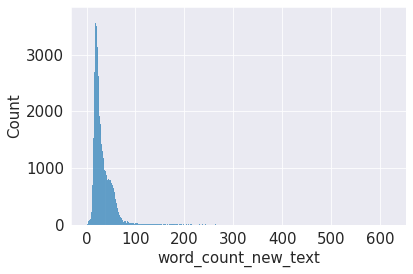

In [48]:
# Number of words in the cleaned Review
review_df['word_count_new_text']= pd.Series([len(item.split()) for item in review_df['new_text']])

# most of the cleaned review
sns.histplot(review_df['word_count_new_text'])

In [49]:
# Finding frequency of all words
all_words= len(cleaner)
print('Total words in clean review is {}'.format(all_words))

word_dist= nltk.FreqDist(cleaner)

# Create dataFrame for word frequency
freg_data_all= pd.DataFrame(word_dist.most_common(all_words), columns= ['Word', 'Frequency'])

# Percertage of word frequency
freg_data_all['PercentFreg_all']= (freg_data_all['Frequency']/freg_data_all['Frequency'].sum())*100
print('No of unique words {}'.format(len(freg_data_all)))
print(freg_data_all.head(50))

Total words in clean review is 2515971
No of unique words 25885
          Word  Frequency  PercentFreg_all
0        phòng      86800         3.449960
1        không      67973         2.701661
2          sạn      52985         2.105946
3    nhân_viên      52915         2.103164
4          tốt      46536         1.849624
5    tuyệt_vời      40259         1.600138
6          đẹp      32768         1.302400
7         sạch      32351         1.285826
8   thân_thiện      26352         1.047389
9          đêm      23364         0.928628
10         bữa      22685         0.901640
11        lịch      19995         0.794723
12        biển      19672         0.781885
13        hàng      18958         0.753506
14        đình      18585         0.738681
15         giá      17472         0.694444
16      chuyến      17363         0.690111
17     dịch_vụ      16729         0.664912
18         thể      16521         0.656645
19         tất      16009         0.636295
20          hồ      15471        

In [50]:
# words which are used only once
(freg_data_all['Frequency']==1).value_counts()

True     13811
False    12074
Name: Frequency, dtype: int64

In [51]:
counter = Counter(review_df['sentiment'])
counter.items()

dict_items([(1, 67091), (0, 11859)])

Class: 1, Number: 67091, Percentage: 84.98
Class: 0, Number: 11859, Percentage: 15.02


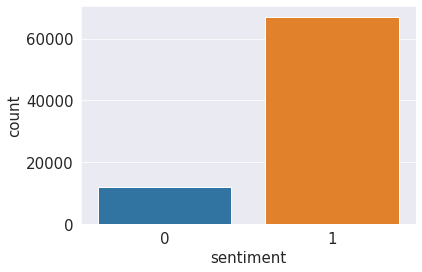

In [52]:
for k, v in counter.items():
    per= v/len(review_df)*100
    print("Class: {}, Number: {}, Percentage: {}".format(k, v, np.round(per, 2)))

sns.countplot(review_df['sentiment'])

###Positive


In [53]:
wordcloud= WordCloud(
    width= 3000,
    height= 2000,
    background_color= 'Black',
    colormap= 'Set2',
    stopwords= stopwords_lst,
    max_words= 100,
    random_state= 0
).generate(str(review_df[review_df['sentiment'] == 1]['new_text']))

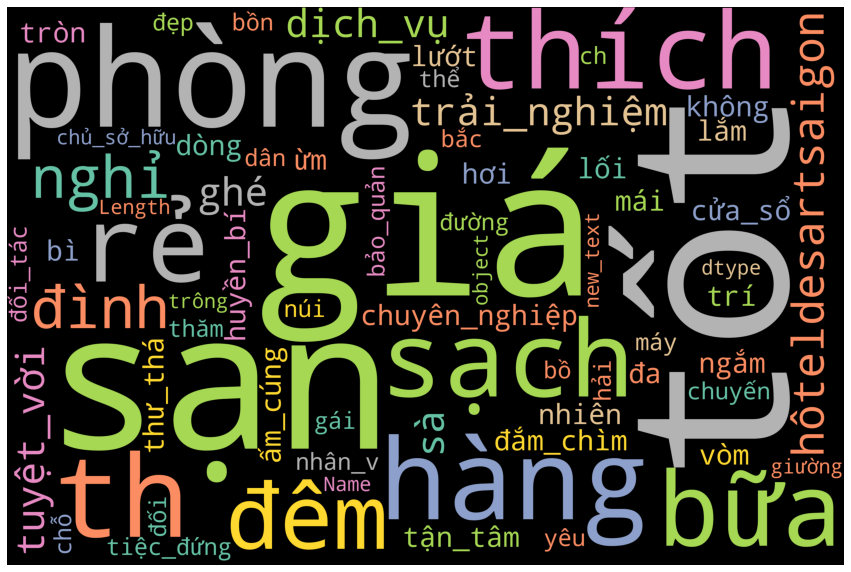

In [54]:
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

###Negative

In [55]:
wordcloud= WordCloud(
    width= 3000,
    height= 2000,
    background_color= 'Black',
    colormap= 'Set2',
    stopwords= stopwords_lst,
    max_words= 100,
    random_state= 0
).generate(str(review_df[review_df['sentiment'] == 0]['new_text']))

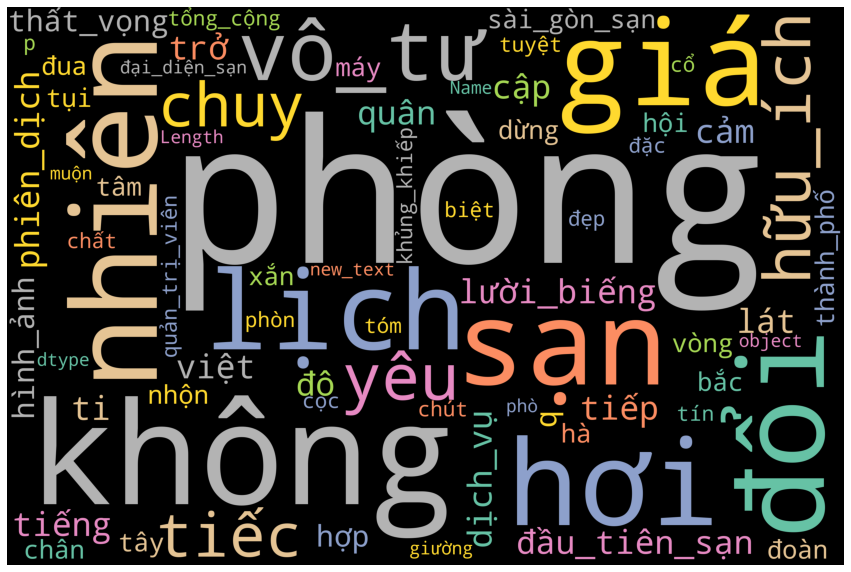

In [56]:
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()